In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pint
ureg = pint.UnitRegistry()

from plotting import plot_unit_sphere
from sources import UniformBeam, GaussianBeam

# The goal
I'm a developer of the [TOPAS](http://topasmc.org) Monte Carlo simulation tool for radiotherapy research. To improve our beam source model, I wanted a method to randomly generate uniformly distributed directions that are constrained to a certain region of the unit sphere, centered upon the z-axis (the beam direction). Generated particles are assigned these random directions before they are transported through the simulated geometry, in order to account for beam divergence. In fact, the final goal was a normal distribution of directions, but I knew I needed a uniform distribution to verify that the method worked.

In our previous situation, we had two methods for generating random directions:

1. **isotropic source**: 
    to generate points uniformly across the entire unit sphere, we sample $u \in [-1, 1]$ and $\phi \in [0, 2\pi)$ from uniform distributions. We then apply the following coordinate transformation (note that $u = \cos\theta$)
    $$\begin{align}
    x &= \sqrt{1-u^2} \cos\phi \\
    y &= \sqrt{1-u^2} \sin\phi \\
    z &= u
    \end{align}$$
    .
2. **beam source**:
    to generate points normally distributed around the z-axis upon the unit sphere, we sample $u_x = \mathcal{N}(0, \cos\theta_x)$ and $u_y = \mathcal{N}(0, \cos\theta_y)$ from normal distributions. Note that $\theta_x$ and $\theta_y$ are user parameters that determine the beam divergence in each plane. We then apply the following coordinate transformation
    $$\begin{align}
    x &= \cos^{-1} u_x \\
    y &= \cos^{-1} u_y \\
    z &= \sqrt{1 - u_x^2 - u_y^2}
    \end{align}$$

The problems with this second method are that it cannot generate uniformly distributed directions and that it is only valid in the small-angle approximation, $\theta_x \ll 1$ and $\theta_y \ll 1$. I wanted a method that could resolve this problems, but our isotropic method did not naturally extend to beams with a direction.

Here is a nice widget to play with the final beam models, and then below I describe how they work.

<IPython.core.display.Javascript object>


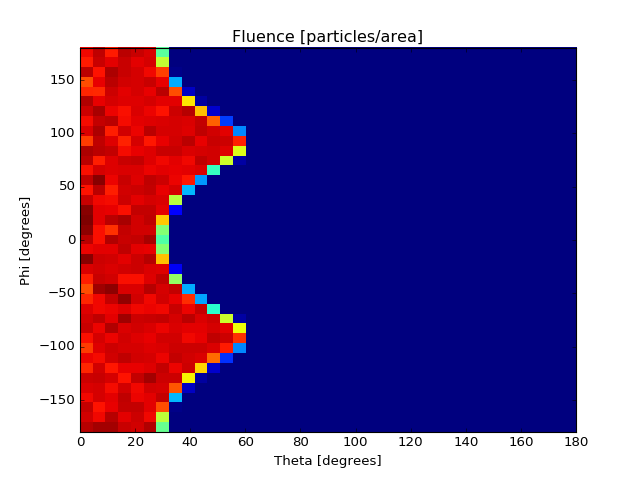

In [2]:
from ipywidgets import interact, FloatSlider, ToggleButtons
from IPython.display import display

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
plt.xlabel('Theta [degrees]')
plt.ylabel('Phi [degrees]')
plt.title('Fluence [particles/area]')

theta_edges = np.linspace(   0, 180, 40)
phi_edges   = np.linspace(-180, 180, 40)

cos_edges = np.cos(np.deg2rad(theta_edges))
bin_wgts = 1./(cos_edges[:-1] - cos_edges[1:])   # solid area depends on theta

def plot_hist(theta_x, theta_y, source_type):
    source = source_type(theta_x*ureg.degree, theta_y*ureg.degree)
    x,y,z = source.generate(1000000)
    
    theta = np.rad2deg(np.arccos(z))
    phi   = np.rad2deg(np.arctan2(y, x))
    wgt = bin_wgts[np.digitize(theta, theta_edges)-1]
    
    ax1.hist2d(theta, phi, bins=[theta_edges,phi_edges], weights=wgt)
    display(fig1)

    
w_theta_x = FloatSlider(min=1e-3, max=180, value=30, description='$\\theta_x$', continuous_update=False)
w_theta_y = FloatSlider(min=1e-3, max=180, value=60, description='$\\theta_y$', continuous_update=False)
w_source = ToggleButtons(options={'Uniform': UniformBeam, 'Gaussian': GaussianBeam}, value=UniformBeam, description='Beam:')
    
_ = interact(plot_hist, theta_x=w_theta_x, theta_y=w_theta_y, source_type=w_source)

# Marsaglia transform
Several different methods of uniformly sampling points on the unit sphere are described in this [Wolfram MathWorld page](http://mathworld.wolfram.com/SpherePointPicking.html). For my purposes, the most useful was a method derived by Marsaglia (1972).

First, points are generated within a unit circle by uniformly sampling $x_1 \in [-1, 1]$ and $x_2 \in [-1, 1]$ and rejecting points with $x_1^2 + x_2^2 \ge 1$. Then the radial distance of each point is used to determine the polar angle of the direction upon the unit sphere. This is achieved with the following coordinate transformation

$$\begin{align}
x &= 2 x_1 \sqrt{1 - x_1^2 - x_2^2} \\
y &= 2 x_2 \sqrt{1 - x_1^2 - x_2^2} \\
z &= 1 - 2(x_1^2 + x_2^2)
\end{align}$$


Here is a helpful visualization of the Marsaglia transformation, courtesy of this [StackOverflow answer](http://math.stackexchange.com/a/838336). The red circle originally has a radius of 1 and is transformed to the south pole. The purple circle originally has a radius of $\sqrt{0.5} \approx 0.71$ and is transformed to the equator. A uniform distribution on the unit disc is transformed into a uniform distribution on the unit sphere.
![Animation of Marsaglia transformation](http://i.stack.imgur.com/qxPG3.gif)

Marsaglia, G. "Choosing a Point from the Surface of a Sphere." *Ann. Math. Stat.* **43**, 645-646, 1972.

# A uniform beam direction generator
The Marsaglia coordinate transform can be used to achieve my goal because I can easily constrain the direction by adjusting how the $(x_1, x_2)$ disk is sampled. That is, by shrinking the radius of the circle I am effectively biasing the beam in a particular direction. By sampling an ellipse instead of a circle, the beam can diverge differently in each plane. The efficiency of the sampling will remain at $\pi/4 \approx 78.5\%$ regardless, which is the area of a bounding box occupied by an ellipse.

So now I need a way to convert from the angle of divergence $\theta_x$ to the Marsaglia coordinate $x_1$ (and similarly for the $y$-plane). The solution is found by inverting the above transformation to yield
$$x_i = \sqrt{ (1 - \cos\theta_i) / 2} \,.$$

Thus the full sampling process becomes
1. convert $\theta_x$ and $\theta_y$ into the semi-major and semi-minor axes of an ellipse
2. uniformly sample $(x_1, x_2)$ points upon this disk
3. transform onto the unit sphere $(x, y, z)$ to obtain a random directions

The Python implementation can be found [here](sources.py).

Efficiency = 80.1%


<IPython.core.display.Javascript object>


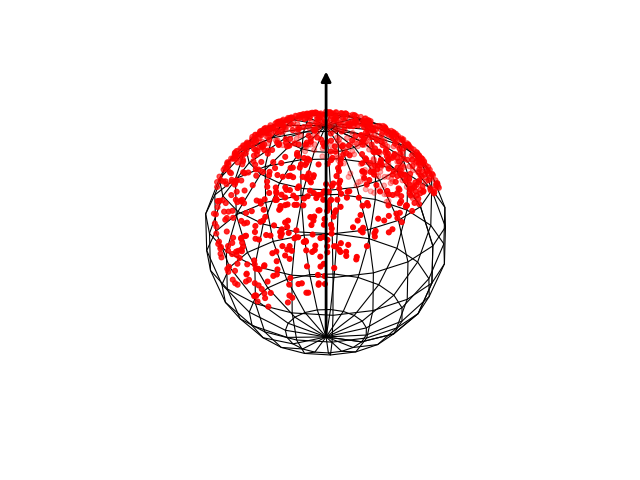

In [3]:
source = UniformBeam(60*ureg.degree, 100*ureg.degree)
x,y,z = source.generate(1000)
print('Efficiency = {:.1%}'.format(source.efficiency()))

fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
plot_unit_sphere(ax2)

ax2.scatter(x,y,z, c='r', s=20, edgecolors='face')

# A bonus direction generator: Gaussian
It is simple to extend the previous direction generator to sample a Gaussian distribution instead of a uniform distribution. Simply sample the Marsaglia disk using a 2D Gaussian distribution before transforming onto the unit sphere. Note that it is necessary to explicitly constrain $x_1^2 + x_2^2 \leq 1$ in this case.

<IPython.core.display.Javascript object>


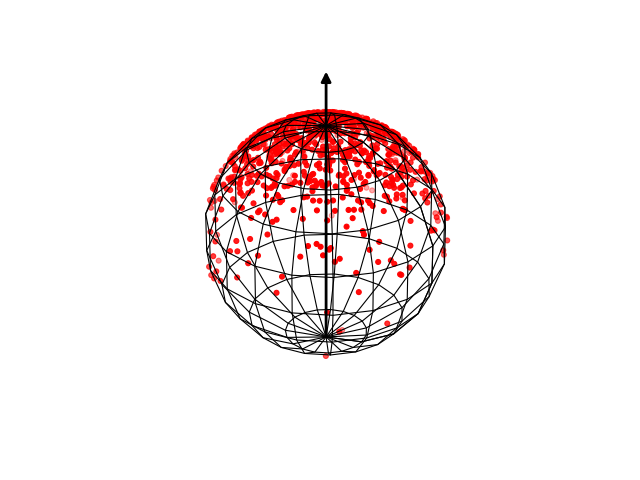

In [4]:
source = GaussianBeam(30*ureg.degree, 30*ureg.degree)
x,y,z = source.generate(1000)

fig3 = plt.figure()
ax3 = fig3.add_subplot(111, projection='3d')
plot_unit_sphere(ax3)

ax3.scatter(x,y,z, c='r', s=20, edgecolors='face')